In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import pyfolio as pf

D:\anaconda\lib\site-packages\pyfolio\pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
D:\anaconda\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sys.path.insert(0, r'../src')
from function_cache import *

In [3]:
# trading day list
wind_trading_day = pd.read_csv(
    r"..\data\raw\meta_data\wind_trading_day.csv",
    index_col="Trading_Day",
    parse_dates=True,
)

In [4]:
# spread price continuous data
T_spread_price = pd.read_csv(
    "../data/processed/spread_price/T_spread_price.csv",
    index_col="Trading_Day",
    parse_dates=True,
)
TF_spread_price = pd.read_csv(
    "../data/processed/spread_price/TF_spread_price.csv",
    index_col="Trading_Day",
    parse_dates=True,
)

In [5]:
# start and end date of roll period
T_roll_period = pd.read_csv(
    "../data/processed/roll_period/T_roll_period.csv", index_col="contract"
).astype("datetime64[ns]")
TF_roll_period = pd.read_csv(
    "../data/processed/roll_period/TF_roll_period.csv", index_col="contract"
).astype("datetime64[ns]")

In [6]:
# close price continuous data
T_Close = pd.read_csv(
    "../data/interim/raw_features/T/T_Close.csv", index_col=0, parse_dates=True
)
TF_Close = pd.read_csv(
    "../data/interim/raw_features/TF/TF_Close.csv", index_col=0, parse_dates=True
)

In [7]:
# list of contract by time sequence
T_contract_list = list(T_Close.columns)
TF_contract_list = list(TF_Close.columns)

In [8]:
T_roll_period

,start,end
contract,,
T1509,NaT,NaT
T1512,2015-07-30,2015-08-19
T1603,2015-10-14,2015-11-20
T1606,2016-01-21,2016-02-19
T1609,2016-04-07,2016-05-12
T1612,2016-06-24,2016-08-16
T1703,2016-10-25,2016-11-10
T1706,2016-12-15,2017-02-09
T1709,2017-04-20,2017-05-15


In [9]:
T_last_record = T_Close.index[-1]
T_dominant_contract = convert_to_intention_day(T_roll_period, wind_trading_day, T_last_record)
TF_last_record = TF_Close.index[-1]
TF_dominant_contract = convert_to_intention_day(TF_roll_period, wind_trading_day, TF_last_record)

T_contracts_sequence = treasury_futures_contracts_sequence(T_dominant_contract)
TF_contracts_sequence = treasury_futures_contracts_sequence(TF_dominant_contract)

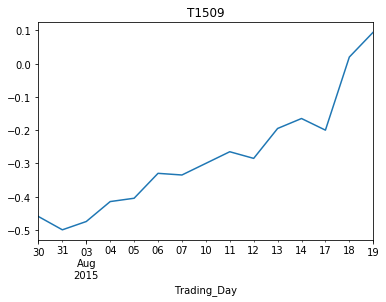

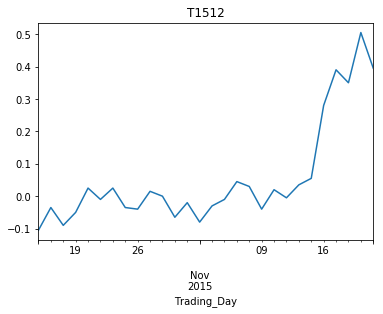

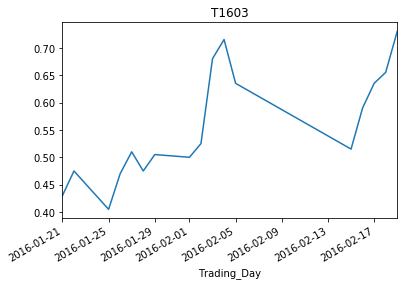

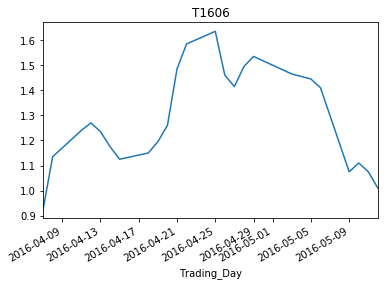

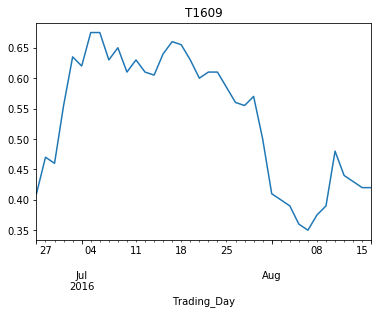

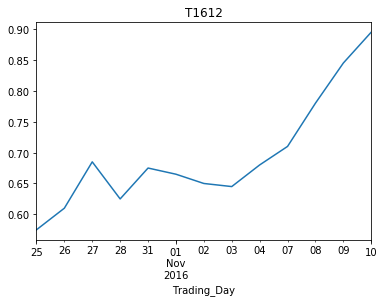

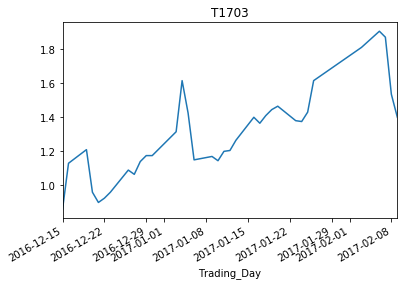

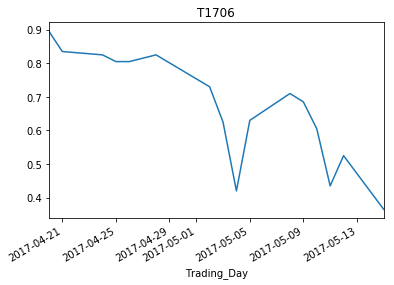

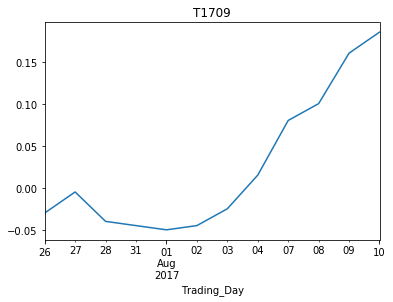

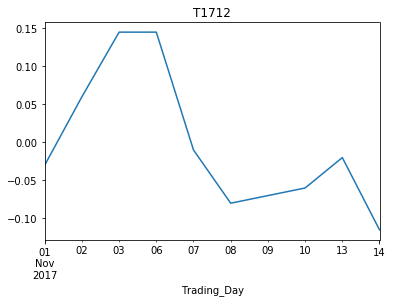

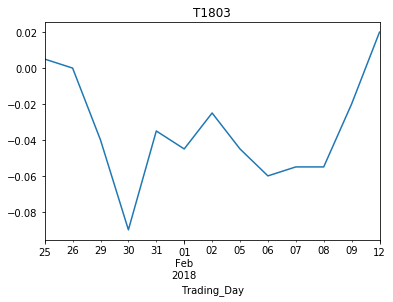

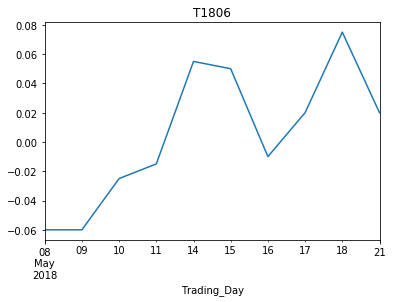

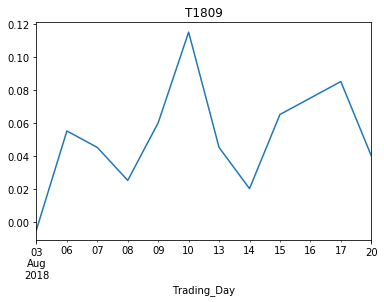

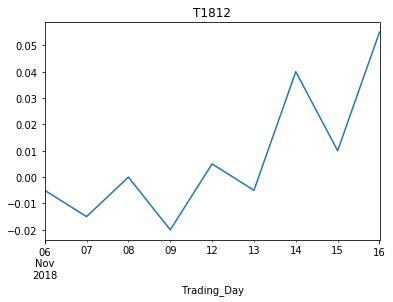

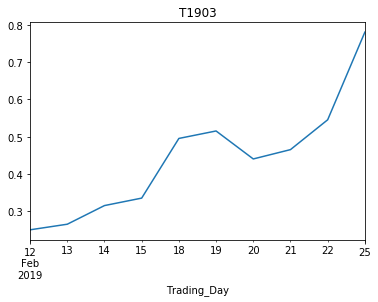

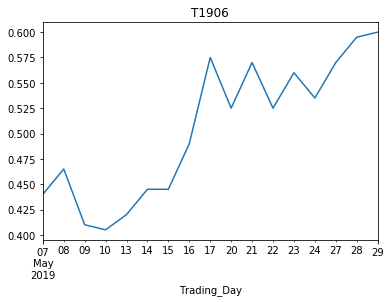

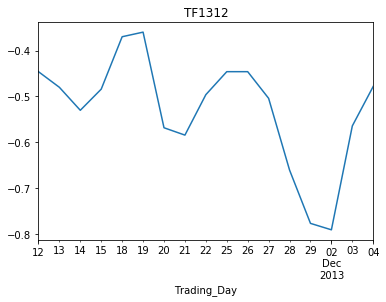

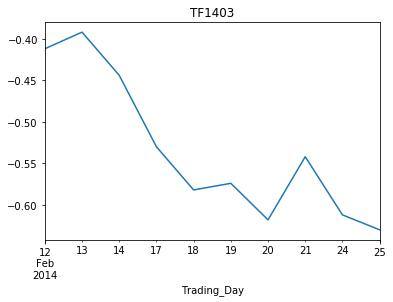

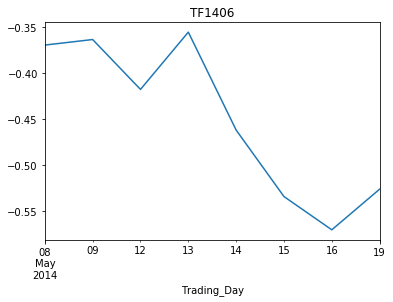

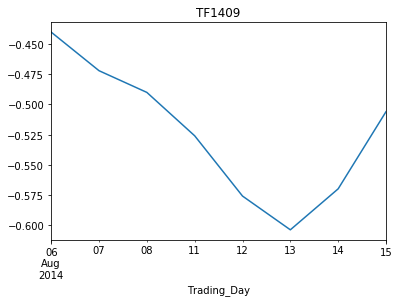

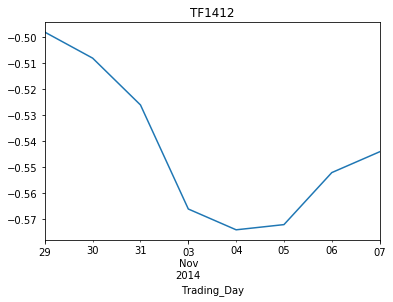

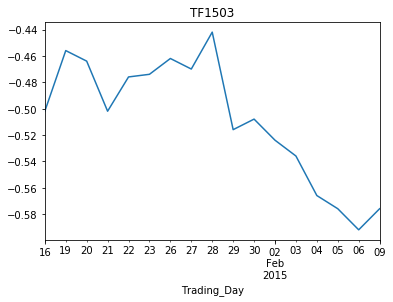

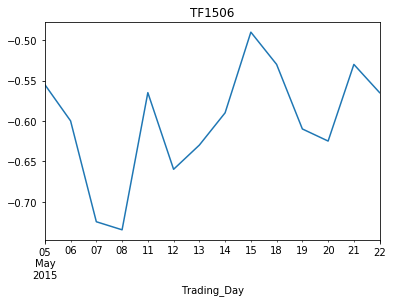

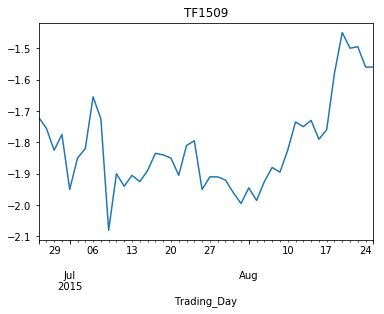

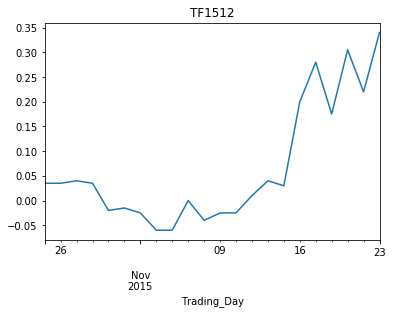

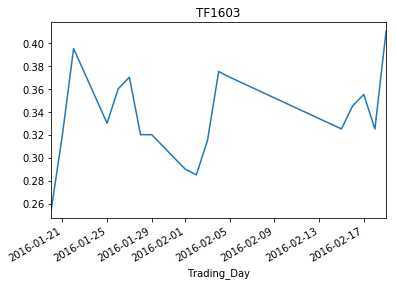

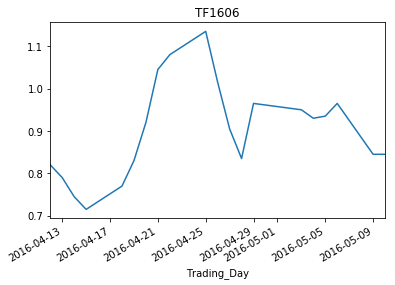

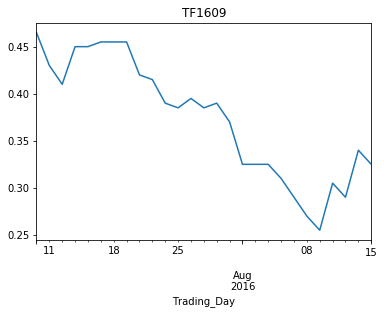

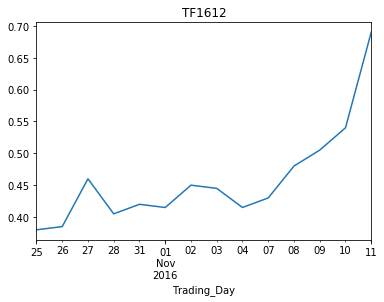

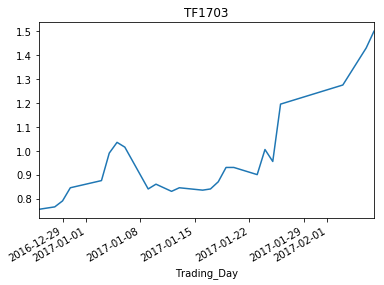

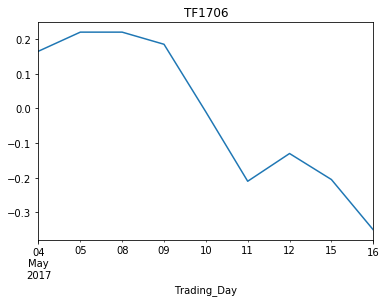

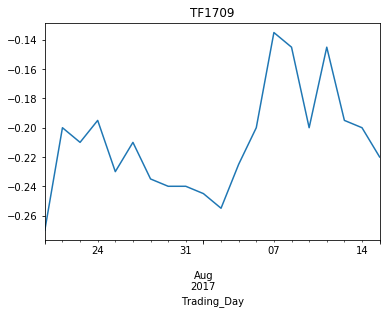

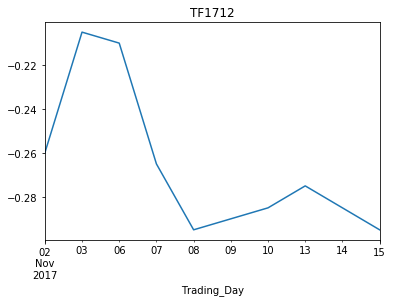

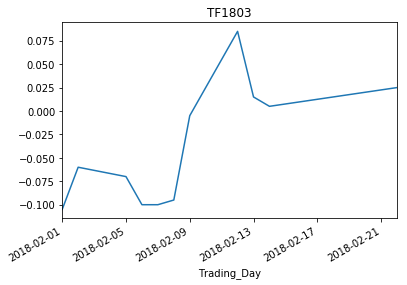

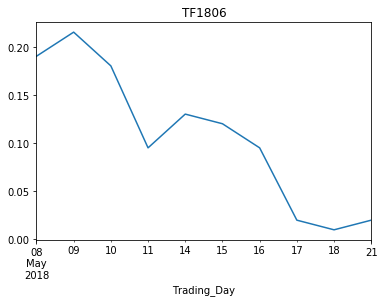

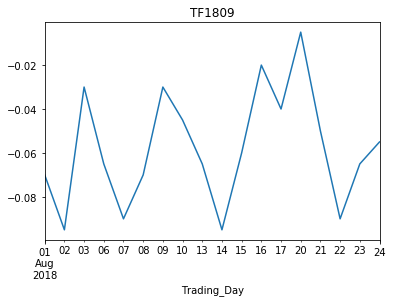

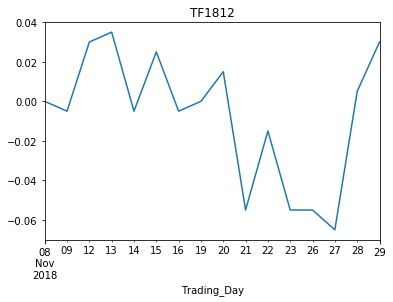

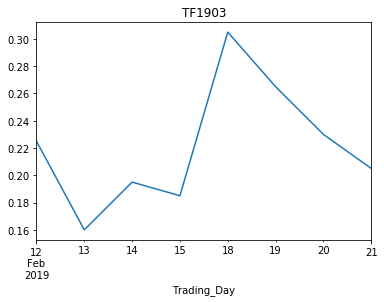

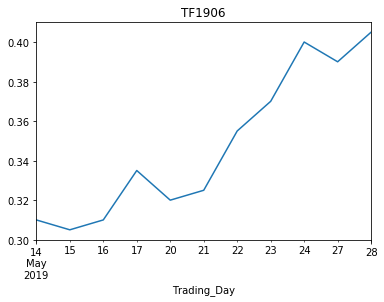

In [10]:
T_spread_change = spread_change_during_roll(T_spread_price, T_roll_period, T_contract_list)
TF_spread_change = spread_change_during_roll(TF_spread_price, TF_roll_period, TF_contract_list)

## T

In [11]:
# get the continuous price
T_price_conti = get_value_df(T_contracts_sequence, T_Close, "price", T_contract_list)
T_price_conti["spread_price"] = T_price_conti["deferred_contract_price"] - T_price_conti["active_contract_price"]
T_price_conti.head()

,active_contract,deferred_contract,further_contract,active_contract_price,deferred_contract_price,further_contract_price,spread_price
Trading_Day,,,,,,,
2015-03-20,T1509,T1512,T1603,97.09,97.435,97.785,0.345
2015-03-23,T1509,T1512,T1603,97.02,97.435,97.100,0.415
2015-03-24,T1509,T1512,T1603,96.92,97.435,97.580,0.515
2015-03-25,T1509,T1512,T1603,96.85,97.500,97.580,0.650
2015-03-26,T1509,T1512,T1603,96.37,97.000,97.580,0.630


In [42]:
T_spread_15d_change = spread_change_before_roll(15, T_price_conti, T_roll_period, T_contract_list)

In [43]:
T_spread_return = T_spread_price.copy()
T_spread_return['spread_price_ret'] = T_spread_return['spread_price'].diff() / 200
T_spread_return = T_spread_return.dropna()
T_spread_return['spread_return'] = None

for active_contract in T_roll_period.shift(-1).dropna().index:
    
    deferred_contract = find_next_contract(active_contract, T_contract_list)
    signal = -np.sign(T_spread_15d_change.loc[active_contract, '15d_spread_change'])
    
    start_date = T_roll_period.loc[deferred_contract, 'start']
    day_after_start = T_spread_price[start_date:].index[1]
    end_date = T_roll_period.loc[deferred_contract, 'end']
    
    ret = T_spread_return.loc[day_after_start:end_date, 'spread_price_ret'] * signal
    T_spread_return.loc[day_after_start:end_date, 'spread_return'] = ret


Start date,2015-03-23
End date,2019-07-15
Total months,50
,Backtest
Annual return,0.4%
Cumulative returns,1.6%
Annual volatility,0.3%
Sharpe ratio,1.20
Calmar ratio,0.88
Stability,0.83
Max drawdown,-0.4%


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.44,2016-04-25,2016-07-04,2016-12-19,171
1,0.25,2017-02-06,2017-02-09,2017-05-15,71
2,0.23,2017-01-04,2017-01-10,2017-02-03,23
3,0.22,2017-08-01,2018-05-18,2019-02-22,409
4,0.15,2016-12-19,2016-12-21,2017-01-03,12


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


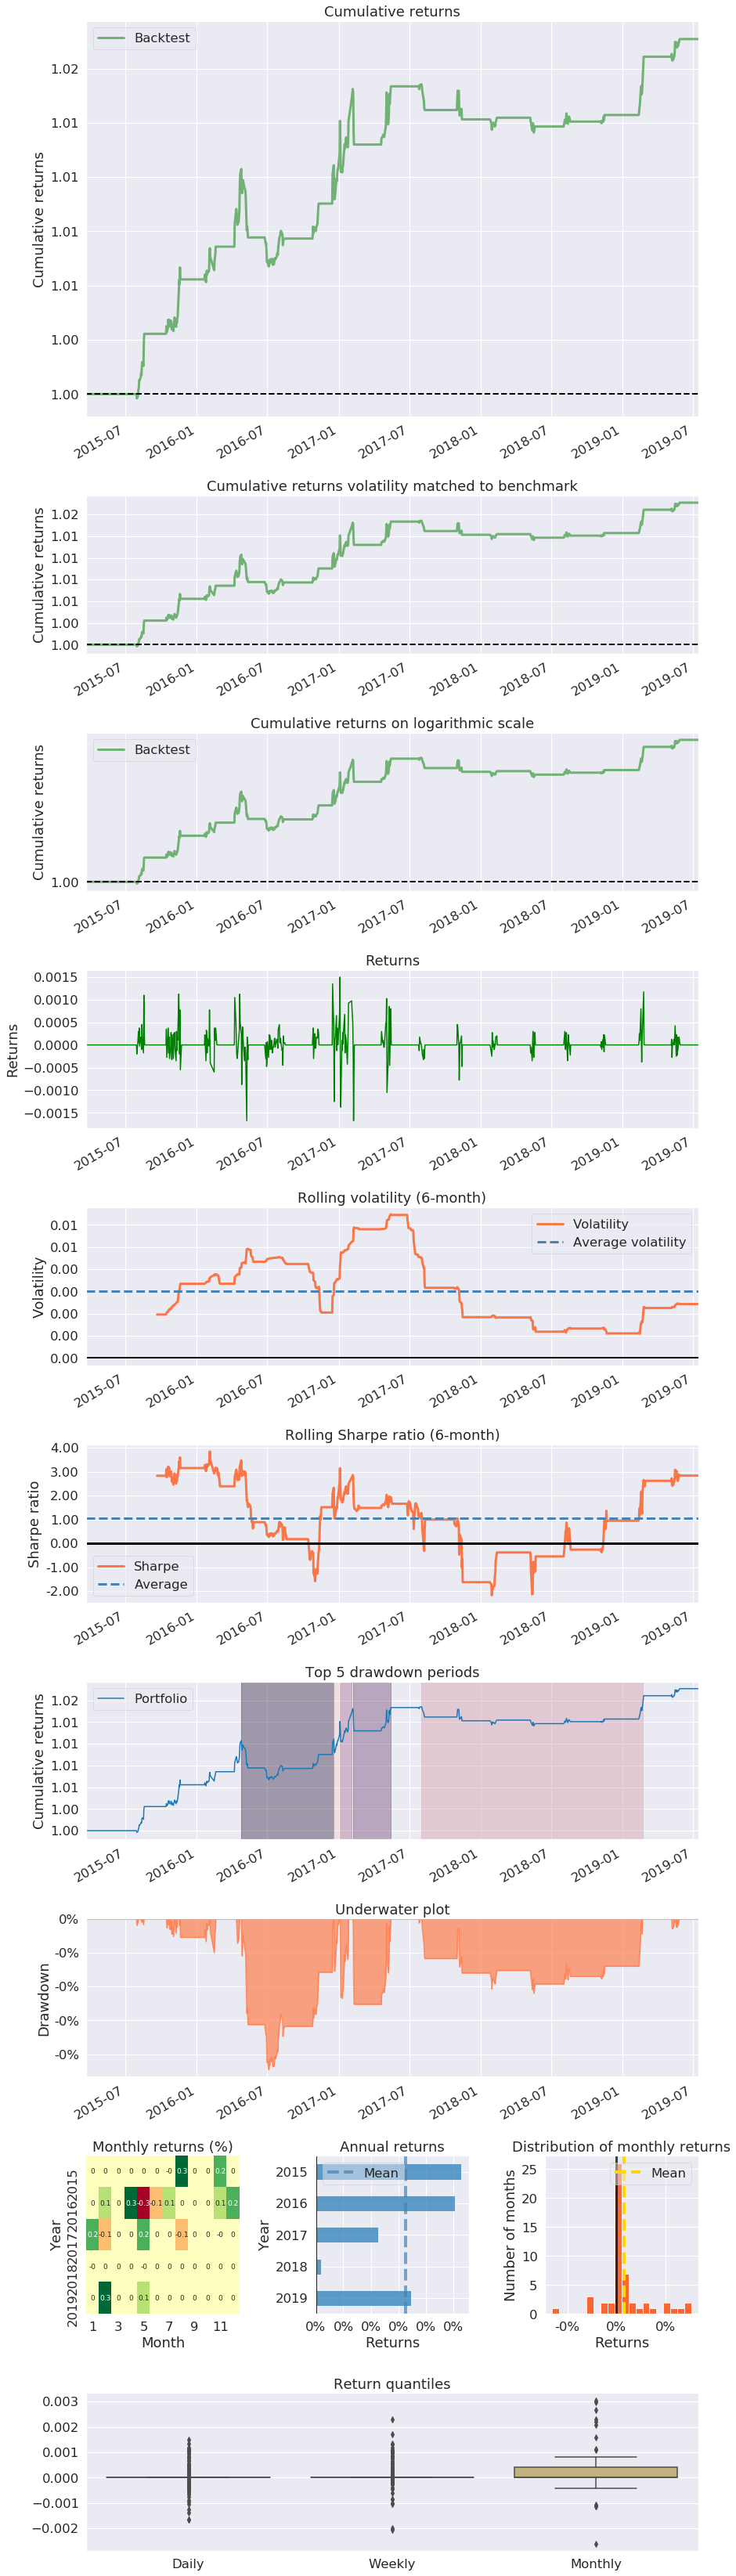

In [44]:
pf.create_returns_tear_sheet(T_spread_return['spread_return'].fillna(0))

2.424 0.016 0.006 0.004 0.693 0.084 2.331


(0.015551548737808174, 0.0064143811876581965, 2.4244815334222185)

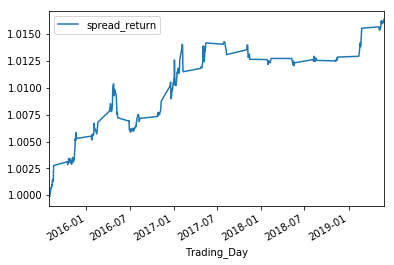

In [45]:
grading_(T_spread_return['spread_return'].dropna().astype(float))

## TF

In [29]:
# get the continuous price
TF_price_conti = get_value_df(TF_contracts_sequence, TF_Close, "price", TF_contract_list)
TF_price_conti["spread_price"] = TF_price_conti["deferred_contract_price"] - TF_price_conti["active_contract_price"]
TF_price_conti.head()

,active_contract,deferred_contract,further_contract,active_contract_price,deferred_contract_price,further_contract_price,spread_price
Trading_Day,,,,,,,
2013-09-06,TF1312,TF1403,TF1406,94.170,94.288,94.344,0.118
2013-09-09,TF1312,TF1403,TF1406,93.906,94.000,94.070,0.094
2013-09-10,TF1312,TF1403,TF1406,93.842,93.930,94.008,0.088
2013-09-11,TF1312,TF1403,TF1406,93.598,93.688,93.766,0.090
2013-09-12,TF1312,TF1403,TF1406,93.728,93.842,93.926,0.114


In [46]:
TF_spread_15d_change = spread_change_before_roll(15, TF_price_conti, TF_roll_period, TF_contract_list)

In [47]:
TF_spread_return = TF_spread_price.copy()
TF_spread_return['spread_price_ret'] = TF_spread_return['spread_price'].diff() / 200
TF_spread_return = TF_spread_return.dropna()
TF_spread_return['spread_return'] = None

for active_contract in TF_roll_period.shift(-1).dropna().index:
    
    deferred_contract = find_next_contract(active_contract, TF_contract_list)
    signal = -np.sign(TF_spread_15d_change.loc[active_contract, '15d_spread_change'])
    
    start_date = TF_roll_period.loc[deferred_contract, 'start']
    day_after_start = TF_spread_price[start_date:].index[1]
    end_date = TF_roll_period.loc[deferred_contract, 'end']
    
    ret = TF_spread_return.loc[day_after_start:end_date, 'spread_price_ret'] * signal
    TF_spread_return.loc[day_after_start:end_date, 'spread_return'] = ret


Start date,2013-09-09
End date,2019-07-15
Total months,67
,Backtest
Annual return,0.1%
Cumulative returns,0.8%
Annual volatility,0.2%
Sharpe ratio,0.60
Calmar ratio,0.30
Stability,0.81
Max drawdown,-0.5%


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.50,2013-12-02,2015-07-08,2016-04-20,623
1,0.25,2016-04-25,2016-08-09,2017-01-04,183
2,0.17,2018-02-12,2019-02-13,NaT,NaN
3,0.10,2017-01-05,2017-01-12,2017-01-26,16
4,0.08,2013-11-14,2013-11-19,2013-11-20,5


D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


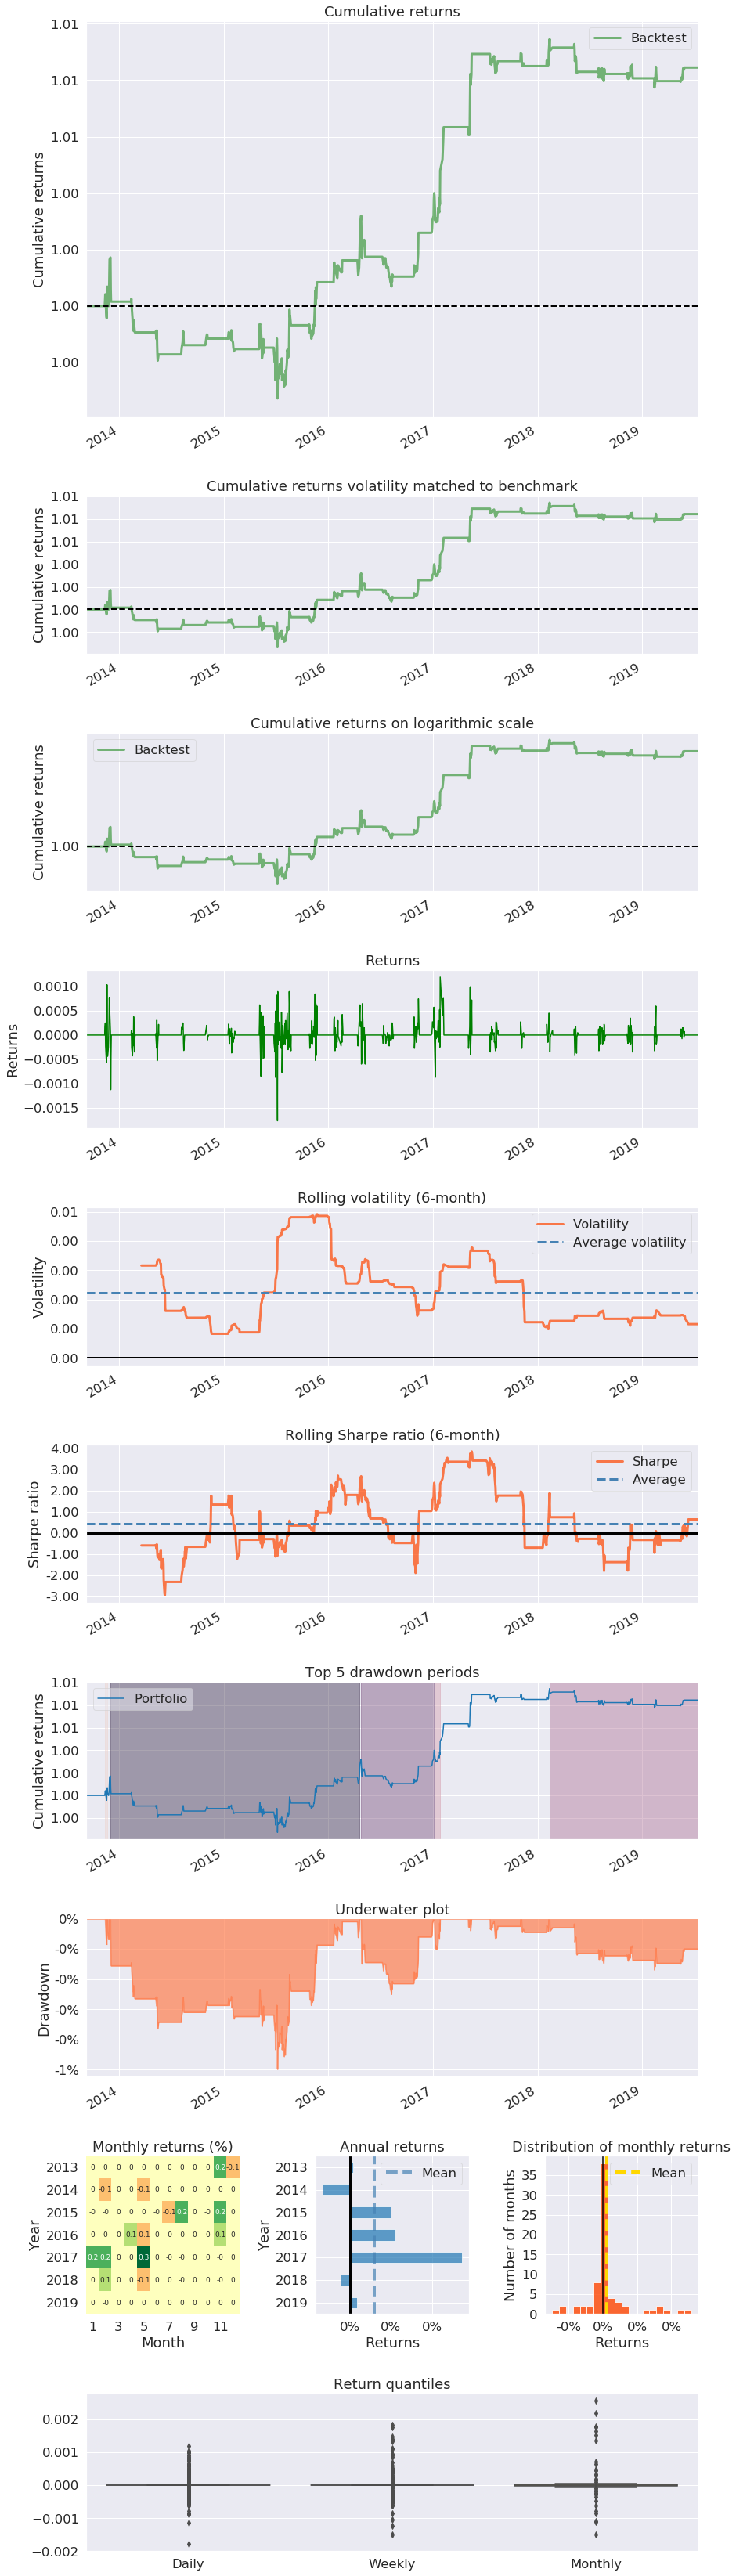

In [48]:
pf.create_returns_tear_sheet(TF_spread_return['spread_return'].fillna(0))

1.219 0.006 0.005 0.005 0.980 0.230 1.206


(0.006199638317789802, 0.005085591575777399, 1.2190594202095566)

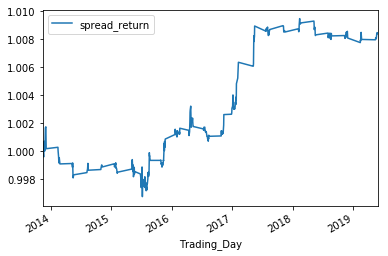

In [49]:
grading_(TF_spread_return['spread_return'].dropna().astype(float))